In [1]:
import logging

import probtorch
import torch

import combinators
import importance
import mcmc
import ssm
import trace_tries
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [4]:
ssm_step = combinators.PrimitiveCall(ssm.ssm_step)
ssm_initializer = combinators.ReturnModel(zs[0], mu, sigma, delta)
ssm_sequence = combinators.Reduce(ssm_step, generator=lambda: range(zs.shape[0]-1), initializer=ssm_initializer)

In [5]:
_, generative = ssm_sequence()

In [6]:
data = {k.rpartition('/')[-1]: rv.value for (k, rv) in generative.filter(lambda k, rv: 'X_' in k)}

In [7]:
particle_shape = (100,)

In [8]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [9]:
init_ssm_generative = combinators.HyperPopulation(ssm.init_ssm, particle_shape, hyper=ssm_params)
ssm_step_generative = combinators.PrimitiveCall(ssm.ssm_step)
ssm_generative = combinators.Reduce(ssm_step_generative, generator=lambda: range(50), initializer=init_ssm_generative)

In [10]:
init_ssm_proposal = combinators.HyperPopulation(ssm.init_ssm, particle_shape, trainable=ssm_params)
ssm_step_proposal = combinators.PrimitiveCall(ssm.ssm_step)
ssm_proposal = importance.smc(ssm_step_proposal, particle_shape, lambda: range(50), initializer=init_ssm_proposal)

In [11]:
ssm_score = combinators.ProposalScore(ssm_proposal, ssm_generative)

In [12]:
inference, init_ssm_params, elbos = importance.variational_importance(
    ssm_score, 1000, data, use_cuda=False,
    lr=1e-2, patience=100
)

11/08/2018 11:16:41 ELBO=-6.29157867e+01 at epoch 1
11/08/2018 11:16:41 ELBO=-6.15690041e+01 at epoch 2
11/08/2018 11:16:41 ELBO=-6.41199875e+01 at epoch 3
11/08/2018 11:16:41 ELBO=-6.46162796e+01 at epoch 4
11/08/2018 11:16:41 ELBO=-6.43477478e+01 at epoch 5
11/08/2018 11:16:41 ELBO=-6.42106400e+01 at epoch 6
11/08/2018 11:16:41 ELBO=-6.52146378e+01 at epoch 7
11/08/2018 11:16:41 ELBO=-6.48874435e+01 at epoch 8
11/08/2018 11:16:41 ELBO=-6.31472092e+01 at epoch 9
11/08/2018 11:16:41 ELBO=-6.28785324e+01 at epoch 10
11/08/2018 11:16:42 ELBO=-6.40534515e+01 at epoch 11
11/08/2018 11:16:42 ELBO=-6.36123428e+01 at epoch 12
11/08/2018 11:16:42 ELBO=-6.66498947e+01 at epoch 13
11/08/2018 11:16:42 ELBO=-6.33562584e+01 at epoch 14
11/08/2018 11:16:42 ELBO=-6.24040527e+01 at epoch 15
11/08/2018 11:16:42 ELBO=-6.26574860e+01 at epoch 16
11/08/2018 11:16:42 ELBO=-6.34639053e+01 at epoch 17
11/08/2018 11:16:42 ELBO=-6.44608917e+01 at epoch 18
11/08/2018 11:16:42 ELBO=-6.17218246e+01 at epoch 19
11

Epoch   168: reducing learning rate of group 0 to 5.0000e-03.


11/08/2018 11:16:56 ELBO=-6.12768364e+01 at epoch 172
11/08/2018 11:16:56 ELBO=-6.18436661e+01 at epoch 173
11/08/2018 11:16:57 ELBO=-6.41977539e+01 at epoch 174
11/08/2018 11:16:57 ELBO=-6.18147850e+01 at epoch 175
11/08/2018 11:16:57 ELBO=-6.41322021e+01 at epoch 176
11/08/2018 11:16:57 ELBO=-6.33099060e+01 at epoch 177
11/08/2018 11:16:57 ELBO=-6.45440979e+01 at epoch 178
11/08/2018 11:16:57 ELBO=-6.24922943e+01 at epoch 179
11/08/2018 11:16:57 ELBO=-6.22243385e+01 at epoch 180
11/08/2018 11:16:57 ELBO=-6.18627281e+01 at epoch 181
11/08/2018 11:16:57 ELBO=-6.26554337e+01 at epoch 182
11/08/2018 11:16:58 ELBO=-6.22391624e+01 at epoch 183
11/08/2018 11:16:58 ELBO=-6.28525810e+01 at epoch 184
11/08/2018 11:16:58 ELBO=-6.28744392e+01 at epoch 185
11/08/2018 11:16:58 ELBO=-6.31773376e+01 at epoch 186
11/08/2018 11:16:58 ELBO=-6.21427536e+01 at epoch 187
11/08/2018 11:16:58 ELBO=-6.30012436e+01 at epoch 188
11/08/2018 11:16:58 ELBO=-6.37000427e+01 at epoch 189
11/08/2018 11:16:58 ELBO=-6.

Epoch   401: reducing learning rate of group 0 to 2.5000e-03.


11/08/2018 11:17:22 ELBO=-6.42322617e+01 at epoch 404
11/08/2018 11:17:23 ELBO=-6.15920219e+01 at epoch 405
11/08/2018 11:17:23 ELBO=-6.36209030e+01 at epoch 406
11/08/2018 11:17:23 ELBO=-6.28155174e+01 at epoch 407
11/08/2018 11:17:23 ELBO=-6.47585068e+01 at epoch 408
11/08/2018 11:17:23 ELBO=-6.19356499e+01 at epoch 409
11/08/2018 11:17:23 ELBO=-6.30710144e+01 at epoch 410
11/08/2018 11:17:23 ELBO=-6.21919174e+01 at epoch 411
11/08/2018 11:17:24 ELBO=-5.92173233e+01 at epoch 412
11/08/2018 11:17:24 ELBO=-6.23091583e+01 at epoch 413
11/08/2018 11:17:24 ELBO=-6.16786652e+01 at epoch 414
11/08/2018 11:17:24 ELBO=-6.16673660e+01 at epoch 415
11/08/2018 11:17:24 ELBO=-6.38262520e+01 at epoch 416
11/08/2018 11:17:24 ELBO=-6.24716301e+01 at epoch 417
11/08/2018 11:17:25 ELBO=-6.13220634e+01 at epoch 418
11/08/2018 11:17:25 ELBO=-6.27629814e+01 at epoch 419
11/08/2018 11:17:25 ELBO=-6.19960213e+01 at epoch 420
11/08/2018 11:17:25 ELBO=-6.32706070e+01 at epoch 421
11/08/2018 11:17:25 ELBO=-6.

Epoch   512: reducing learning rate of group 0 to 1.2500e-03.


11/08/2018 11:17:36 ELBO=-6.35331841e+01 at epoch 515
11/08/2018 11:17:37 ELBO=-6.24552155e+01 at epoch 516
11/08/2018 11:17:37 ELBO=-6.08550034e+01 at epoch 517
11/08/2018 11:17:37 ELBO=-6.27303772e+01 at epoch 518
11/08/2018 11:17:37 ELBO=-6.26723442e+01 at epoch 519
11/08/2018 11:17:37 ELBO=-6.12285423e+01 at epoch 520
11/08/2018 11:17:37 ELBO=-6.32766495e+01 at epoch 521
11/08/2018 11:17:37 ELBO=-6.32848167e+01 at epoch 522
11/08/2018 11:17:37 ELBO=-6.20646667e+01 at epoch 523
11/08/2018 11:17:37 ELBO=-6.32589149e+01 at epoch 524
11/08/2018 11:17:38 ELBO=-6.21274109e+01 at epoch 525
11/08/2018 11:17:38 ELBO=-6.24580345e+01 at epoch 526
11/08/2018 11:17:38 ELBO=-6.33306427e+01 at epoch 527
11/08/2018 11:17:38 ELBO=-6.21928329e+01 at epoch 528
11/08/2018 11:17:38 ELBO=-6.16873093e+01 at epoch 529
11/08/2018 11:17:38 ELBO=-6.37050323e+01 at epoch 530
11/08/2018 11:17:38 ELBO=-6.30884628e+01 at epoch 531
11/08/2018 11:17:38 ELBO=-6.17826195e+01 at epoch 532
11/08/2018 11:17:38 ELBO=-6.

Epoch   613: reducing learning rate of group 0 to 6.2500e-04.


11/08/2018 11:17:48 ELBO=-6.10233727e+01 at epoch 616
11/08/2018 11:17:48 ELBO=-6.38807144e+01 at epoch 617
11/08/2018 11:17:48 ELBO=-6.27542839e+01 at epoch 618
11/08/2018 11:17:48 ELBO=-6.23209419e+01 at epoch 619
11/08/2018 11:17:48 ELBO=-6.19177933e+01 at epoch 620
11/08/2018 11:17:48 ELBO=-6.26231613e+01 at epoch 621
11/08/2018 11:17:49 ELBO=-6.23653336e+01 at epoch 622
11/08/2018 11:17:49 ELBO=-6.38244591e+01 at epoch 623
11/08/2018 11:17:49 ELBO=-6.18912392e+01 at epoch 624
11/08/2018 11:17:49 ELBO=-6.32812843e+01 at epoch 625
11/08/2018 11:17:49 ELBO=-6.37698784e+01 at epoch 626
11/08/2018 11:17:49 ELBO=-6.23326645e+01 at epoch 627
11/08/2018 11:17:49 ELBO=-6.47290802e+01 at epoch 628
11/08/2018 11:17:49 ELBO=-6.18627281e+01 at epoch 629
11/08/2018 11:17:50 ELBO=-6.22788277e+01 at epoch 630
11/08/2018 11:17:50 ELBO=-6.25160942e+01 at epoch 631
11/08/2018 11:17:50 ELBO=-6.25002098e+01 at epoch 632
11/08/2018 11:17:50 ELBO=-6.22227859e+01 at epoch 633
11/08/2018 11:17:50 ELBO=-6.

Epoch   714: reducing learning rate of group 0 to 3.1250e-04.


11/08/2018 11:17:59 ELBO=-6.23990250e+01 at epoch 717
11/08/2018 11:17:59 ELBO=-6.32760811e+01 at epoch 718
11/08/2018 11:17:59 ELBO=-6.23906097e+01 at epoch 719
11/08/2018 11:17:59 ELBO=-6.23270340e+01 at epoch 720
11/08/2018 11:18:00 ELBO=-6.18143692e+01 at epoch 721
11/08/2018 11:18:00 ELBO=-6.41304321e+01 at epoch 722
11/08/2018 11:18:00 ELBO=-6.26790009e+01 at epoch 723
11/08/2018 11:18:00 ELBO=-6.29461288e+01 at epoch 724
11/08/2018 11:18:00 ELBO=-6.23954468e+01 at epoch 725
11/08/2018 11:18:00 ELBO=-6.42826614e+01 at epoch 726
11/08/2018 11:18:00 ELBO=-6.14858017e+01 at epoch 727
11/08/2018 11:18:01 ELBO=-6.34217224e+01 at epoch 728
11/08/2018 11:18:01 ELBO=-6.33185730e+01 at epoch 729
11/08/2018 11:18:01 ELBO=-6.12372284e+01 at epoch 730
11/08/2018 11:18:01 ELBO=-6.22612762e+01 at epoch 731
11/08/2018 11:18:01 ELBO=-6.17468567e+01 at epoch 732
11/08/2018 11:18:01 ELBO=-6.28764534e+01 at epoch 733
11/08/2018 11:18:01 ELBO=-6.13594971e+01 at epoch 734
11/08/2018 11:18:02 ELBO=-6.

Epoch   815: reducing learning rate of group 0 to 1.5625e-04.


11/08/2018 11:18:11 ELBO=-6.46944580e+01 at epoch 818
11/08/2018 11:18:11 ELBO=-6.19794044e+01 at epoch 819
11/08/2018 11:18:11 ELBO=-6.36099281e+01 at epoch 820
11/08/2018 11:18:11 ELBO=-6.35696449e+01 at epoch 821
11/08/2018 11:18:12 ELBO=-6.43662491e+01 at epoch 822
11/08/2018 11:18:12 ELBO=-6.31503143e+01 at epoch 823
11/08/2018 11:18:12 ELBO=-6.34926872e+01 at epoch 824
11/08/2018 11:18:12 ELBO=-6.19501038e+01 at epoch 825
11/08/2018 11:18:12 ELBO=-6.39611969e+01 at epoch 826
11/08/2018 11:18:12 ELBO=-6.23598709e+01 at epoch 827
11/08/2018 11:18:12 ELBO=-6.45243454e+01 at epoch 828
11/08/2018 11:18:12 ELBO=-6.23324661e+01 at epoch 829
11/08/2018 11:18:12 ELBO=-6.13741493e+01 at epoch 830
11/08/2018 11:18:13 ELBO=-6.28745270e+01 at epoch 831
11/08/2018 11:18:13 ELBO=-6.21649017e+01 at epoch 832
11/08/2018 11:18:13 ELBO=-6.30780487e+01 at epoch 833
11/08/2018 11:18:13 ELBO=-6.21839981e+01 at epoch 834
11/08/2018 11:18:13 ELBO=-6.31430435e+01 at epoch 835
11/08/2018 11:18:13 ELBO=-6.

Epoch   916: reducing learning rate of group 0 to 7.8125e-05.


11/08/2018 11:18:23 ELBO=-6.04091911e+01 at epoch 920
11/08/2018 11:18:23 ELBO=-6.37041626e+01 at epoch 921
11/08/2018 11:18:23 ELBO=-6.08367271e+01 at epoch 922
11/08/2018 11:18:23 ELBO=-6.31764221e+01 at epoch 923
11/08/2018 11:18:23 ELBO=-6.24252739e+01 at epoch 924
11/08/2018 11:18:23 ELBO=-6.18110619e+01 at epoch 925
11/08/2018 11:18:23 ELBO=-6.12829018e+01 at epoch 926
11/08/2018 11:18:23 ELBO=-6.18016624e+01 at epoch 927
11/08/2018 11:18:23 ELBO=-6.36137886e+01 at epoch 928
11/08/2018 11:18:23 ELBO=-6.31249771e+01 at epoch 929
11/08/2018 11:18:24 ELBO=-6.21777573e+01 at epoch 930
11/08/2018 11:18:24 ELBO=-6.39022026e+01 at epoch 931
11/08/2018 11:18:24 ELBO=-6.19361076e+01 at epoch 932
11/08/2018 11:18:24 ELBO=-6.29701805e+01 at epoch 933
11/08/2018 11:18:24 ELBO=-6.20606346e+01 at epoch 934
11/08/2018 11:18:24 ELBO=-6.43166809e+01 at epoch 935
11/08/2018 11:18:24 ELBO=-6.19677429e+01 at epoch 936
11/08/2018 11:18:24 ELBO=-6.33051987e+01 at epoch 937
11/08/2018 11:18:25 ELBO=-6.

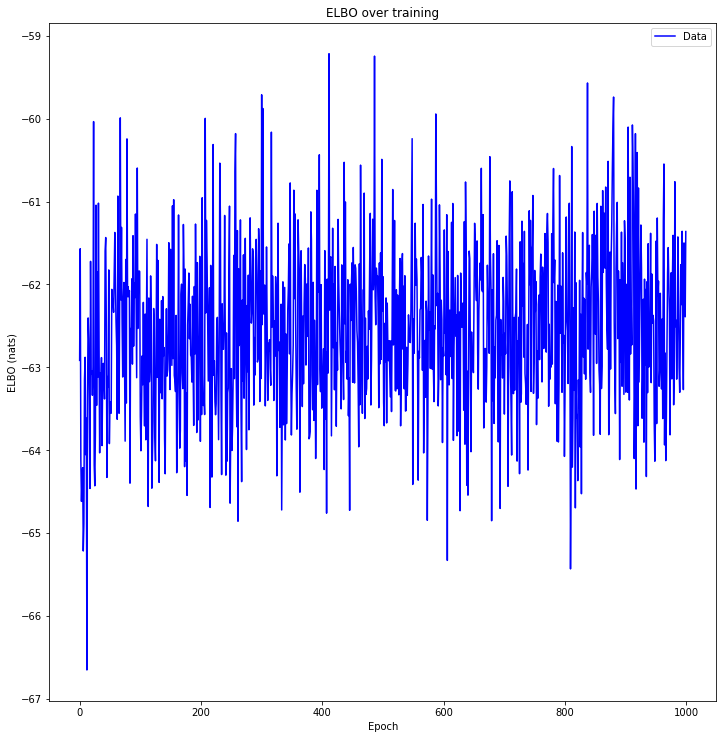

In [13]:
utils.plot_evidence_bounds(elbos)

In [14]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 2.725696
SMC MSE at time 2: 0.536050
SMC MSE at time 3: 1.405117
SMC MSE at time 4: 1.150197
SMC MSE at time 5: 0.923342
SMC MSE at time 6: 1.211744
SMC MSE at time 7: 0.908635
SMC MSE at time 8: 0.709708
SMC MSE at time 9: 0.786843
SMC MSE at time 10: 0.804849
SMC MSE at time 11: 0.810883
SMC MSE at time 12: 0.564113
SMC MSE at time 13: 1.208091
SMC MSE at time 14: 1.308231
SMC MSE at time 15: 0.916694
SMC MSE at time 16: 1.146782
SMC MSE at time 17: 0.631266
SMC MSE at time 18: 0.973069
SMC MSE at time 19: 1.009131
SMC MSE at time 20: 1.054588
SMC MSE at time 21: 2.277000
SMC MSE at time 22: 0.776685
SMC MSE at time 23: 0.687589
SMC MSE at time 24: 1.136526
SMC MSE at time 25: 0.835196
SMC MSE at time 26: 2.892797
SMC MSE at time 27: 1.583791
SMC MSE at time 28: 0.623343
SMC MSE at time 29: 0.838559
SMC MSE at time 30: 0.651715
SMC MSE at time 31: 1.185412
SMC MSE at time 32: 0.990031
SMC MSE at time 33: 0.912354
SMC MSE at time 34: 3.345611
SMC MSE at time 35: 1.5

In [15]:
particle_mh = mcmc.independent_mh(ssm_score, 1000)

In [16]:
lookup = utils.dict_lookup(data)
inference = trace_tries.HierarchicalTrace(observations=lookup)
samples, inference = particle_mh(trace=inference)

In [17]:
inference

In [18]:
generative

In [28]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

KeyError: 'Reduce(ssm_step)'

In [ ]:
elbos